# Surface Image Segmentation 

## Imports

In [4]:
import numpy as np

from tqdm import tqdm
import glob

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [72]:
!nvidia-smi

Sat Jan 21 15:24:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:B3:00.0 Off |                    0 |
| N/A   38C    P0    55W / 300W |  32298MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Colab

In [ ]:
%%script echo skipping 

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/DS-Project/"

## U-Net Model

In [73]:
# double convolutional layer which is executed in every step of the u-net 
# conv layer takes as input number of input channels -> in_channels and outputs vice versa
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    # forward pass in the conv layer 
    def forward(self, x):
        return self.conv(x)

# design complete u-net shape 
# model takes as default 3 input channels and 6 output channels
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=6, features=[64, 128, 256, 512],  # features -> num of input nodes at every stage in the model 
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):  # reverse the features i.o. to move upwards in the model 
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        # lowest stage in u-net 
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # final conv layer: takes in 64 channels and outputs 1 channel by default 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    # forward pass of the u-net model between stages 
    def forward(self, x):
        skip_connections = []  # red arrows in the model representation 

        for down in self.downs:
            x = down(x)  # one DoubleConv run-through 
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [74]:
%%script echo skipping 
    
x = torch.randn((3, 1, 161, 161))
model = UNET(in_channels=1, out_channels=1)
print(model)
preds = model(x)
assert preds.shape == x.shape

skipping


## Dataset

In [75]:
imgs = glob.glob('/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/2_Ortho_RGB/*tif')
labels = glob.glob("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/Labels_all/*tif")

# create dictionary -> {key: 'link/to/image_or_label'}
labels_dict = {label.split("/")[-1].split(".")[0].rsplit('_', 1)[0] : label for label in labels}
imgs_dict = {img.split("/")[-1].split(".")[0].rsplit('_', 1)[0] : img for img in imgs}

keys = sorted(list(set(imgs_dict)))

In [76]:
%%script echo skipping 

# check if keys in both dicts are the same 
print(set(imgs_dict) == set(labels_dict))

# inspect dicts
print(keys[:5])
print(labels_dict[keys[0]])
print(imgs_dict[keys[0]])

skipping


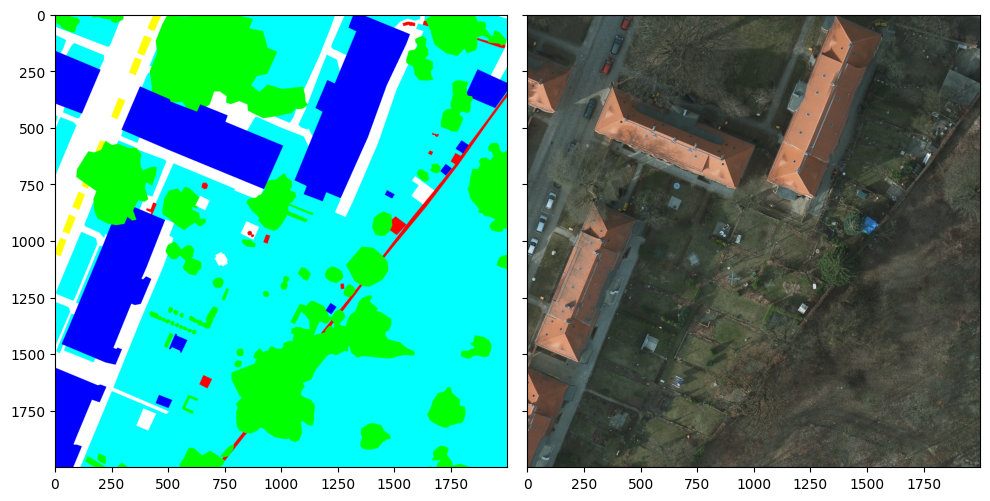

In [77]:
im1 = Image.open(labels_dict[keys[0]]).resize((2000, 2000))
im2 = Image.open(imgs_dict[keys[0]]).resize((2000, 2000))

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1) 
ax[1].imshow(im2) 

f.tight_layout()
plt.show()

- Impervious surfaces (RGB: 255, 255, 255)      | white 
- Building (RGB: 0, 0, 255)                     | blue 
- Low vegetation (RGB: 0, 255, 255)             | light-blue
- Tree (RGB: 0, 255, 0)                         | green            
- Car (RGB: 255, 255, 0)                        | yellow
- Clutter/background (RGB: 255, 0, 0)           | red

### Custom data set class

In [78]:
class PotsdamDataset(Dataset):
    def __init__(self, imgs_dict, labels_dict, keys, transform=None):
        self.img_dir = imgs_dict
        self.mask_dir = labels_dict
        self.keys = keys
        self.transform = transform
        
        self.RGB_classes = {
            'imprevious' : [255, 255, 225],
            'building' : [0,  0, 255],
            'low_vegetation' : [0, 255, 255],
            'tree' : [0,  255,  0], 
            'car' : [ 255, 255, 0],
            'background' : [255, 0, 0]
            }  # in RGB
        
        self.bin_classes = ['imprevious', 'building', 'low_vegetation', 'tree', 'car', 'background']

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        img_path = self.img_dir[self.keys[idx]]
        mask_path = self.mask_dir[self.keys[idx]]
        
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))
        
        cls_mask = np.zeros(mask.shape) # dim: (6000, 6000, 3)
        
        # Six to four classes: (imprevious + car + background) joined
        cls_mask[(mask == self.RGB_classes['imprevious']).all(-1)] = self.bin_classes.index('imprevious')
        cls_mask[(mask == self.RGB_classes['building']).all(-1)] = self.bin_classes.index('building')
        cls_mask[(mask == self.RGB_classes['low_vegetation']).all(-1)] = self.bin_classes.index('low_vegetation')
        cls_mask[(mask == self.RGB_classes['tree']).all(-1)] = self.bin_classes.index('tree')
        cls_mask[(mask == self.RGB_classes['car']).all(-1)] = self.bin_classes.index('imprevious')
        cls_mask[(mask == self.RGB_classes['background']).all(-1)] = self.bin_classes.index('imprevious')
        cls_mask = cls_mask[:,:,0] # omit last dimension (, , 3) -> RGB  

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=cls_mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

#### Testing the class

In [79]:
y = np.array(Image.open(labels_dict[keys[0]]))
x = np.zeros(y.shape)

RGB_classes = {
            'imprevious' : [255, 255, 225],
            'building' : [0,  0, 255],
            'low_vegetation' : [0, 255, 255],
            'tree' : [0,  255,  0], 
            'car' : [ 255, 255, 0],
            'background' : [255, 0, 0]
            }  # in RGB

bin_classes = ['imprevious', 'building', 'low_vegetation', 'tree', 'car', 'background']

x[(y == RGB_classes['imprevious']).all(-1)] = bin_classes.index('imprevious')
x[(y == RGB_classes['building']).all(-1)] = bin_classes.index('building')
x[(y == RGB_classes['low_vegetation']).all(-1)] = bin_classes.index('low_vegetation')
x[(y == RGB_classes['tree']).all(-1)] = bin_classes.index('tree')
x[(y == RGB_classes['car']).all(-1)] = bin_classes.index('car')
x[(y == RGB_classes['background']).all(-1)] = bin_classes.index('background')
x = x[:,:,0]

x[:15, :15]

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3.],
       [2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.],
       [2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3.

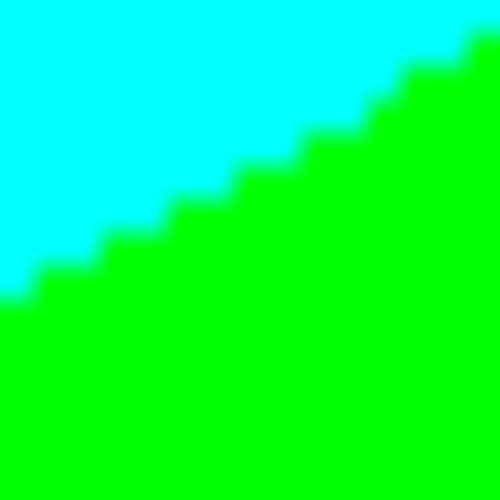

In [80]:
im = Image.open(labels_dict[keys[0]])
 
# Setting the points for cropped image
left = 0
top = 0
right = 15
bottom = 15

# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
 
im1.resize((500, 500))

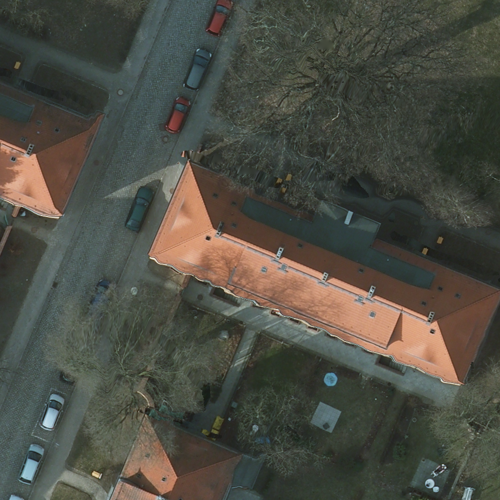

In [81]:
im = Image.open(imgs_dict[keys[0]])
 
# Setting the points for cropped image
left = 0
top = 0
right = 1000
bottom = 1000

# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
im1.resize((500, 500))

## Utils 

### Train-/Test-Split

In [82]:
dataset = PotsdamDataset(imgs_dict, labels_dict, keys)
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

### Data Loader

In [83]:
def get_loaders(
    imgs_dict,
    labels_dict,
    keys,
    batch_size,
    train_transform,
    val_transform,
    num_workers = 2,
    pin_memory = True,
):
    
    train_data = PotsdamDataset(
        imgs_dict = imgs_dict,
        labels_dict = labels_dict,
        keys = keys, 
        transform = train_transform,
    )
    
    valid_data = PotsdamDataset(
        imgs_dict = imgs_dict,
        labels_dict = labels_dict,
        keys = keys, 
        transform = val_transform,
    )

    train_loader = DataLoader(
        train_data,
        batch_size = batch_size,
        num_workers = num_workers,
        pin_memory = pin_memory,
        sampler = train_sampler,
    )

    val_loader = DataLoader(
        valid_data,
        batch_size = batch_size,
        num_workers = num_workers,
        pin_memory = pin_memory,
        sampler = valid_sampler
    )

    return train_loader, val_loader

### Transform Functions

In [5]:
def build_transforms(image_heigt, image_width): 
    
    train_transform = A.Compose([
        A.RandomCrop(width=2000, height=2000, p=0.8),
        A.Resize(height=image_heigt, width=image_width),
        A.Flip(p=0.5),
        A.ToGray(p=0.25),
        A.ColorJitter(p=0.25),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        ],)

    val_transform = A.Compose([
        A.Resize(height=image_heigt, width=image_width),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        ],)
    
    return train_transform, val_transform

### Evaluation Function 

In [85]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            
            # compute probabilities
            probs = torch.nn.Softmax(model(x))
            
            # get predictions by choosing highest probability 
            preds = torch.argmax(probs.dim, axis=1).cpu()
            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)

    print(
        f"Got {num_correct}/{num_pixels} pixels correct with acc {num_correct/num_pixels*100:.2f}"
    )

### Save & Load Model

In [86]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

## Training

In [87]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 10

DICT_IMGS = imgs_dict
LABELS_DICT = labels_dict
KEYS = keys
IMAGE_HEIGHT = 1000  # 6000 originally
IMAGE_WIDTH = 1000  # 6000 originally

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False


def train_fn(loader, model, optimizer, loss_fn, scaler):
    
    model.train()
    loop = tqdm(loader, desc="Training")
    
    for batch_idx, (data, targets) in enumerate(loop):
        
        data = data.to(device=DEVICE)
        targets = targets.type(torch.LongTensor).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    
    train_transform, val_transform = build_transforms(
        image_heigt=IMAGE_HEIGHT, 
        image_width=IMAGE_WIDTH)

    train_loader, val_loader = get_loaders(
        DICT_IMGS, 
        LABELS_DICT,
        KEYS, 
        BATCH_SIZE,
        train_transform,
        val_transform,
        NUM_WORKERS,
        PIN_MEMORY,
    )
    
    MODEL = UNET(in_channels=3, out_channels=6).to(device=DEVICE)
    CRITERION = nn.CrossEntropyLoss().to(device=DEVICE)
    OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), MODEL)

    # check_accuracy(val_loader, model, device=DEVICE)
    SCALER = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        print(f"Start epoch: {epoch+1}")
        
        train_fn(train_loader, MODEL, OPTIMIZER, CRITERION, SCALER)

        # save model
        checkpoint = {
            "state_dict": MODEL.state_dict(),
            "optimizer": OPTIMIZER.state_dict(),
        }
        save_checkpoint(checkpoint)
        
        # check accuracy
        check_accuracy(val_loader, MODEL, device=DEVICE)
        
        print(f"End epoch: {epoch+1} \n")

In [89]:
print(f"Cuda available: {torch.cuda.is_available()} ")
main()

Cuda available: True 
Start epoch: 1


Training: 100%|██████████| 18/18 [01:49<00:00,  6.09s/it, loss=1.29]


=> Saving checkpoint
Got 2496410/6120000 pixels correct with acc 40.79
End epoch: 1 

Start epoch: 2


Training: 100%|██████████| 18/18 [01:48<00:00,  6.04s/it, loss=1.56]


=> Saving checkpoint
Got 3604221/6120000 pixels correct with acc 58.89
End epoch: 2 

Start epoch: 3


Training: 100%|██████████| 18/18 [01:49<00:00,  6.07s/it, loss=1.16]


=> Saving checkpoint
Got 3916613/6120000 pixels correct with acc 64.00
End epoch: 3 

Start epoch: 4


Training: 100%|██████████| 18/18 [01:47<00:00,  5.95s/it, loss=1.17] 


=> Saving checkpoint
Got 4099668/6120000 pixels correct with acc 66.99
End epoch: 4 

Start epoch: 5


Training: 100%|██████████| 18/18 [01:47<00:00,  5.95s/it, loss=1.05] 


=> Saving checkpoint
Got 4086747/6120000 pixels correct with acc 66.78
End epoch: 5 

Start epoch: 6


Training: 100%|██████████| 18/18 [01:48<00:00,  6.02s/it, loss=1.05] 


=> Saving checkpoint
Got 4104875/6120000 pixels correct with acc 67.07
End epoch: 6 

Start epoch: 7


Training: 100%|██████████| 18/18 [01:48<00:00,  6.04s/it, loss=1.09] 


=> Saving checkpoint
Got 4244609/6120000 pixels correct with acc 69.36
End epoch: 7 

Start epoch: 8


Training: 100%|██████████| 18/18 [01:47<00:00,  5.96s/it, loss=0.926]


=> Saving checkpoint
Got 4240873/6120000 pixels correct with acc 69.30
End epoch: 8 

Start epoch: 9


Training: 100%|██████████| 18/18 [01:47<00:00,  5.97s/it, loss=1.33] 


=> Saving checkpoint
Got 4295564/6120000 pixels correct with acc 70.19
End epoch: 9 

Start epoch: 10


Training: 100%|██████████| 18/18 [01:47<00:00,  5.95s/it, loss=0.717]


=> Saving checkpoint
Got 4380148/6120000 pixels correct with acc 71.57
End epoch: 10 



## Predictions

In [25]:
def model_predict(image, model, dataset, image_height, image_width, device="cuda", no_val_resize=False):

    img = np.array(image.convert("RGB"))

    # Convert image to tensor & transform
    _, val_transform = build_transforms(
        image_heigt=image_height, 
        image_width=image_width)
    
    if no_val_resize:
        val_transform.transforms.remove(val_transform.transforms[0])
    
    img = val_transform(image=img)
    pic = img['image']

    model.eval()
    with torch.no_grad():
        # Use image + pretend batch size of 1
        pic = pic.to(device).unsqueeze(0)

        # Compute probabilities
        probs = torch.nn.Softmax(model(pic)).dim
        # Get predictions by choosing highest probability 
        preds = torch.argmax(probs, axis=1).cpu().squeeze(0)

        # Initialise empty arrays for RGB classes and RGB values
        classes = np.empty((preds.shape[0], preds.shape[1]), dtype="<S14")
        img_rgb = np.empty((preds.shape[0], preds.shape[1], 3))

        # Convert numeric labels to RGB classes
        for cl in dataset.bin_classes:
            classes[preds.detach().numpy() == dataset.bin_classes.index(cl)] = cl
            
        # Convert RGB classes to RGB values 
        for key, rgb in dataset.RGB_classes.items():
            img_rgb[classes == str.encode(key), :] = rgb

        return img_rgb.astype(int)

In [102]:
trained_model = UNET(in_channels=3, out_channels=6).to(device='cuda')
load_checkpoint(torch.load("my_checkpoint_68acc.pth.tar"), trained_model)

=> Loading checkpoint


In [107]:
size = 1000
img = Image.open(imgs_dict[keys[3]])
label = Image.open(labels_dict[keys[3]]).resize((size, size))

predictions = model_predict(
    image=img, 
    model=trained_model, 
    dataset=dataset, 
    image_height=size, 
    image_width=size)

predictions.shape

(1000, 1000, 3)

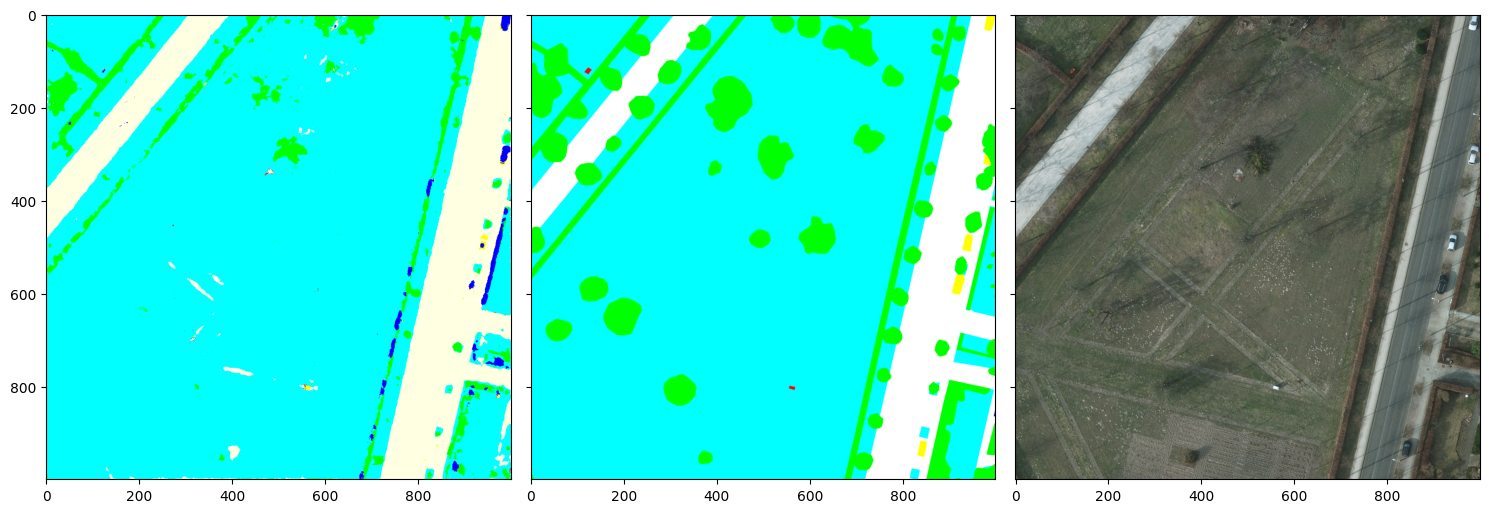

In [108]:
im1 = predictions
im2 = label
im3 = img.resize((size, size))

f, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)
ax[2].imshow(im3)

f.tight_layout()
plt.show()

### Ear Prediction 

In [ ]:
input_img = Image.open("Link/zu/Felix/Ohren")

plt.imshow(input_img)
plt.show()

In [ ]:
# Setting the cordinates for cropped image
x_left = 5000
x_right = 6500

y_top = 4000
y_bottom = 5500

# Cropped image of above dimension
# (It will not change original image)
input_img_cropped = input_img.crop((x_left, y_top, x_right, y_bottom))

plt.imshow(input_img_cropped)
plt.show()

In [ ]:
size = 1000
predictions = model_predict(
    image=input_img_cropped, 
    model=trained_model, 
    dataset=dataset, 
    image_height=size, 
    image_width=size)
predictions.shape

In [ ]:
im1 = predictions
im2 = input_img_cropped

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)

f.tight_layout()
plt.show()